In [1]:
import glob

from fastai.text import *
import sentencepiece as spm #https://github.com/google/sentencepiece

from prod.sp_tok import *

In [2]:
PATH = Path('./data/rnn')
sp_model = './all_tweets_es_0609'

defaults.text_spec_tok.append(NL) #add a New Line special char
sp_vocab = Vocab( get_itos(sp_model) )
mycust_tok = CustomTokenizer(SPTokenizer,sp_model,pre_rules=default_rules)

In [3]:
test_df = pd.read_csv('./data/haha_2019_test.csv')
test_df['is_humor'] = 0
test_df['is_humor'].iloc[0] = 1 #create two classes in data.

raw_text = test_df.loc[:,'text']
print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")
for rule in default_rules:
    raw_text = raw_text.apply(lambda x: rule(str(x)))    
test_df['new_text'] =  raw_text #tokenizer adds xxbos

data_tst = TextClasDataBunch.from_df(PATH, test_df, test_df,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='is_humor')

In [4]:
model_wt_fnames = [x.split('/')[-1] for x in glob.glob( str(PATH/'models')+'/haha_clas_0609_fld*.pth')]
len(model_wt_fnames), model_wt_fnames[:5]

(15,
 ['haha_clas_0609_fld0_105422.pth',
  'haha_clas_0609_fld0_389450.pth',
  'haha_clas_0609_fld1_248367.pth',
  'haha_clas_0609_fld4_389450.pth',
  'haha_clas_0609_fld2_248367.pth'])

In [6]:
!grep Clas ./prod/out_fwd_1.txt > ./by_seed_fwd_perf

In [7]:
## be more picky about the models.  Take the top quarter in validation. Does better val -> better test?
valid_perf = pd.read_csv('by_seed_fwd_perf', names = ['id','acc','F1'])
valid_perf['rnd_seed'] = valid_perf.id.str.split(':',expand=True).iloc[:,-1].str.strip()
valid_perf['nfold'] = valid_perf.id.str.split(' ',expand=True).iloc[:,2]
valid_perf.head()

,id,acc,F1,rnd_seed,nfold
0,Clas Fold: 0 RndSeed: 389450,0.858958,0.813797,389450,0
1,Clas Fold: 1 RndSeed: 389450,0.868125,0.821648,389450,1
2,Clas Fold: 2 RndSeed: 389450,0.871042,0.828729,389450,2
3,Clas Fold: 3 RndSeed: 389450,0.863958,0.815693,389450,3
4,Clas Fold: 4 RndSeed: 389450,0.857292,0.816662,389450,4


Text(0.5, 1.0, 'Freq of F1 over all Random Seeds (20) \n Vert line = MaxValue')

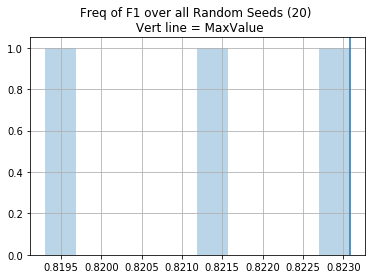

In [8]:
valid_perf.groupby('rnd_seed')['F1'].mean().hist(alpha=0.3)
plt.axvline(x=valid_perf.groupby('rnd_seed')['F1'].mean().max())
plt.title('Freq of F1 over all Random Seeds (20) \n Vert line = MaxValue')

In [9]:
valid_perf.groupby('rnd_seed')['F1'].mean().describe()

count    3.000000
mean     0.821271
std      0.001892
min      0.819306
25%      0.820367
50%      0.821429
75%      0.822254
max      0.823080
Name: F1, dtype: float64

In [10]:
seed_grouped_F1 = valid_perf.groupby('rnd_seed')['F1'].mean()

## best of all sampled seeds
selected_seeds = seed_grouped_F1[seed_grouped_F1>=seed_grouped_F1.max()].index.values.tolist()
seed_fold_pair = valid_perf[valid_perf.rnd_seed.isin(selected_seeds)].loc[:,['rnd_seed','nfold']].values
model_wt_fnames = []
for (seed,fold) in seed_fold_pair:
    model_wt_fnames.append(f'haha_clas_0609_fld{fold}_{seed}.pth')
model_wt_fnames

['haha_clas_0609_fld0_248367.pth',
 'haha_clas_0609_fld1_248367.pth',
 'haha_clas_0609_fld2_248367.pth',
 'haha_clas_0609_fld3_248367.pth',
 'haha_clas_0609_fld4_248367.pth']

In [11]:
ensemble_preds = []
for wt_fname in model_wt_fnames:
    config = awd_lstm_clas_config.copy()
    config['qrnn'] = True
    config['n_hid'] = 2304
    
    learn = text_classifier_learner(data_tst, AWD_LSTM, drop_mult=0.7,pretrained=False,
                               config=config)
    learn = learn.load(wt_fname.split('.')[0]) #load weights
    preds_t,y_t,losses_t = learn.get_preds(DatasetType.Valid,with_loss=True, ordered=True)
    ensemble_preds.append(to_np(preds_t))

In [12]:
np.array(ensemble_preds).shape

(5, 6000, 2)

In [13]:
ens_mean = np.array(ensemble_preds).mean(axis=0)
ens_mean

array([[0.238477, 0.761523],
       [0.921819, 0.078181],
       [0.079422, 0.920578],
       [0.976196, 0.023804],
       ...,
       [0.635782, 0.364218],
       [0.950017, 0.049983],
       [0.34033 , 0.65967 ],
       [0.235313, 0.764687]], dtype=float32)

In [14]:
out_df = test_df['id'].to_frame().copy()
out_df['is_humor'] = ens_mean.argmax(axis=1)
out_df['funniness_average'] = 3.

In [15]:
out_df.head()

,id,is_humor,funniness_average
0,tweet1,1,3.0
1,tweet2,0,3.0
2,tweet3,1,3.0
3,tweet4,0,3.0
4,tweet5,0,3.0


In [16]:
out_df.to_csv('sub0610_finetune_bestSeed.csv',header=True,index=False)